In [37]:
import h5py as h5
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipdb import set_trace
from torch.utils.data import DataLoader as dl
from torch.utils.data import Dataset as ds
from torch import nn
from torch import optim
from torch.nn import functional as F
%matplotlib inline

### Dataset

In [2]:
BATCH_SIZE = 5
NUM_EPOCHS = 1
index = 0
torch.cuda.device(torch.cuda.device('cuda:0'))

class MNIST_3D_DS(ds):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, ind):
        return self.data[ind]
    def __len__(self):
        return len(self.data)
with h5.File('../../../239_748156_bundle_archive/train_point_clouds.h5', 'r') as hf:
    train_set = dl(MNIST_3D_DS([torch.Tensor(x['img']).cuda() for x in hf.values()]), batch_size=BATCH_SIZE)

with h5.File('../../../239_748156_bundle_archive/test_point_clouds.h5', 'r') as hf:
    test_set = dl(MNIST_3D_DS([torch.Tensor(x['img']).cuda() for x in hf.values()]), batch_size=BATCH_SIZE)


### Viz_tools

In [71]:
img_lst = list(Img for i, Img in enumerate(train_set))
img = img_lst[100].cpu().numpy()
def visualize(img):
    # build voxel data
    xdata = np.array([ i + img.shape[1]/2 for i in range(len(img)) for j in range(img.shape[1] * img.shape[2])])
    ydata = np.array([ j for i in range(len(img)) for j in range(img.shape[1]) for k in range(img.shape[2])])
    zdata = np.array([ k for i in range(len(img)) for j in range(img.shape[1]) for k in range(img.shape[2])])
    cdata = np.array([ img[i,j,k] for i in range(len(img)) for j in range(img.shape[1]) for k in range(img.shape[2])])

    # remove white space for transparency 
    rm_list = [i for i in range(len(cdata)) if cdata[i] < 0.3 ]
    xdata = np.delete(xdata, rm_list)
    ydata = np.delete(ydata, rm_list)
    zdata = np.delete(zdata, rm_list)
    cdata = np.delete(cdata, rm_list)

    # stretch the graph for equal-scale aspect
    # xdata = np.insert(xdata, len(xdata), [0, 30])
    # ydata = np.insert(ydata, len(ydata), [0, 30])
    # zdata = np.insert(zdata, len(zdata), [0, 30])
    # cdata = np.insert(cdata, len(cdata), [0, 0])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(xdata, ydata, zdata, c=cdata, cmap='Greens')
    plt.show()

def dot_plot(arr):
    fig = plt.plot(arr)
    plt.ylabel('d_loss')
    plt.show()

### Model

In [204]:
class Discriminator(nn.Module):
    def __init__(self, n_channels, n_class=1):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv3d(1, n_channels // 8, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv3d(n_channels // 8, n_channels // 4, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm3d(n_channels // 4)
        self.conv3 = nn.Conv3d(n_channels // 4, n_channels, kernel_size=2, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(n_channels)
        self.conv4 = nn.Conv3d(n_channels, n_class, kernel_size=2, stride=1, padding=0)
        
    def forward(self, x):
        h1 = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        h2 = F.leaky_relu(self.bn2(self.conv2(h1)), negative_slope=0.2)
        h3 = F.leaky_relu(self.bn3(self.conv3(h2)), negative_slope=0.2)
        h4 = self.conv4(h3)
        output = h4
        
        return output
    
class Generator(nn.Module):
    def __init__(self, n_channels, n_class=1):
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.
        )
    def forward(self, x):
        pass

In [205]:
D = Discriminator(512)
D.cuda()

d_optim = optim.Adam(D.parameters(), lr=0.0002)

ce_loss = nn.CrossEntropyLoss()

### Training

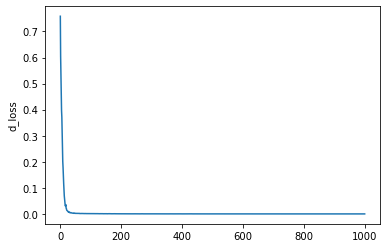

In [206]:
d_losses = []
for index, img in enumerate(train_set):
    # train discriminator
    for param in D.parameters():
        param.requires_grad = True
    # fake and real inputs
    rand = torch.rand(img.shape).unsqueeze(0).unsqueeze(0).cuda()
    img = img.unsqueeze(0).unsqueeze(0)
    # fake and real scores
    real_score = D(img).mean().abs().reshape([1, 1])
    fake_score = D(rand).mean().abs().reshape([1, 1])
    scores = torch.cat((real_score, fake_score), 1)
    d_loss = ce_loss(scores, torch.zeros(1, dtype=torch.long).cuda())
    d_loss.backward()
    d_optim.step()
    d_losses.append(d_loss.item())
    d_optim.zero_grad()
dot_plot(d_losses)

### Testing

In [121]:
for i, img in enumerate(test_set):
    rand = torch.rand(img.shape).unsqueeze(0).unsqueeze(0).cuda()
    img = img.unsqueeze(0).unsqueeze(0) 
    real_score = D(img).mean().abs().reshape([1, 1])
    fake_score = D(rand).mean().abs().reshape([1, 1])
    print(real_score.item(), fake_score.item())
    if i > 100:
        break

9.537906646728516 0.1330365091562271
9.769834518432617 0.08735457807779312
10.102949142456055 0.16573823988437653
10.006412506103516 0.07603238523006439
10.031155586242676 0.10158079117536545
10.06180191040039 0.027875997126102448
9.99491024017334 0.09878090023994446
10.004103660583496 0.03407953307032585
10.131213188171387 0.07532183825969696
9.90632438659668 0.07421695441007614
10.036004066467285 0.05049269273877144
9.691668510437012 0.15772710740566254
9.954278945922852 0.07186523824930191
10.151328086853027 0.03790263831615448
9.92078971862793 0.002518498105928302
9.947385787963867 0.1154850497841835
10.041269302368164 0.002130664186552167
9.846789360046387 0.03600922226905823
9.862650871276855 0.1388208568096161
10.069513320922852 0.08860508352518082
10.115144729614258 0.19918164610862732
10.067679405212402 0.16436763107776642
10.28243350982666 0.20248927175998688
9.501506805419922 0.01449623890221119
9.90865421295166 0.18445239961147308
9.970686912536621 0.1770058423280716
10.183